# Vanilla models test

- Artificial Neural Networks
- Decision Tree Classifier
- Random Forest
- Gradient Boosting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15646807969239454957
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 161352923102905139
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset loading

In [4]:
train = pd.read_csv("data/train.csv")
valid = pd.read_csv("data/valid.csv")
test  = pd.read_csv("data/test.csv")

Reducing the data

In [5]:
def random_n_images(df,no_imgs=10000,shuffle=False):
    each_label_images = int(no_imgs / 2)
    subset_label_0 = df[df['label'] == 0].sample(n=each_label_images, random_state=69)
    subset_label_1 = df[df['label'] == 1].sample(n=each_label_images, random_state=69)
    final_subset = pd.concat([subset_label_0, subset_label_1]) 
    if shuffle == True:
        final_subset = final_subset.sample(frac=1, random_state=42).reset_index(drop=True)
    return final_subset

train_subset = random_n_images(train,no_imgs=10000,shuffle=True)
valid_subset = random_n_images(valid,no_imgs=2000,shuffle=True)
test_subset = random_n_images(test,no_imgs=2000,shuffle=True)

Converting to tensors

In [6]:
BATCH_SIZE = 32
image_height = 256
image_width = 256

In [7]:
train_tfds = tf.data.Dataset.from_tensor_slices((train_subset['path'].values,train_subset['label'].values))
valid_tfds = tf.data.Dataset.from_tensor_slices((valid_subset['path'].values,valid_subset['label'].values))
test_tfds = tf.data.Dataset.from_tensor_slices((test_subset['path'].values,test_subset['label'].values))

def read_image(image_file, label):
    image = tf.io.read_file("data/real_vs_fake/real-vs-fake/" + image_file)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augument(image, label):
    return image, label

BATCH_SIZE = 32
train_tfds = train_tfds.map(read_image).map(augument).batch(BATCH_SIZE)
valid_tfds = valid_tfds.map(read_image).map(augument).batch(1)
test_tfds = test_tfds.map(read_image).map(augument).batch(1)

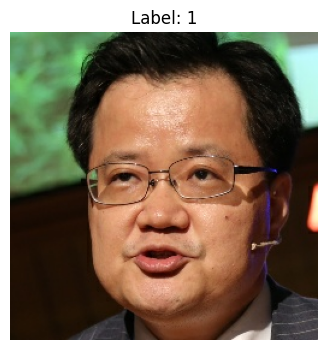

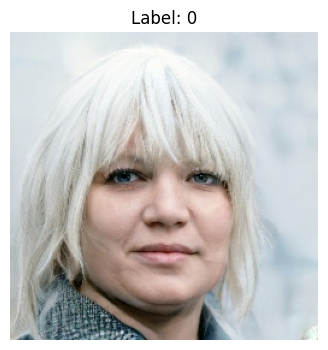

In [8]:
for images, labels in train_tfds.take(1):  # Adjust the number of batches as needed
    for i in range(2):
        plt.figure(figsize=(4, 4))
        plt.imshow(images[i, :, :, :].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
        plt.show()

### old method

In [9]:
train_dir = 'data/real_vs_fake/real-vs-fake/train'
valid_dir = 'data/real_vs_fake/real-vs-fake/valid'
test_dir =  'data/real_vs_fake/real-vs-fake/test'

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
batch_size = 32
image_height = 256
image_width = 256

# Create the generators for training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=True,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',     # Set the class mode to 'binary' since have two classes
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


fake images have label 0 and real images have label 1

In [7]:
classes = list(train_generator.class_indices.keys())
classes

['fake', 'real']

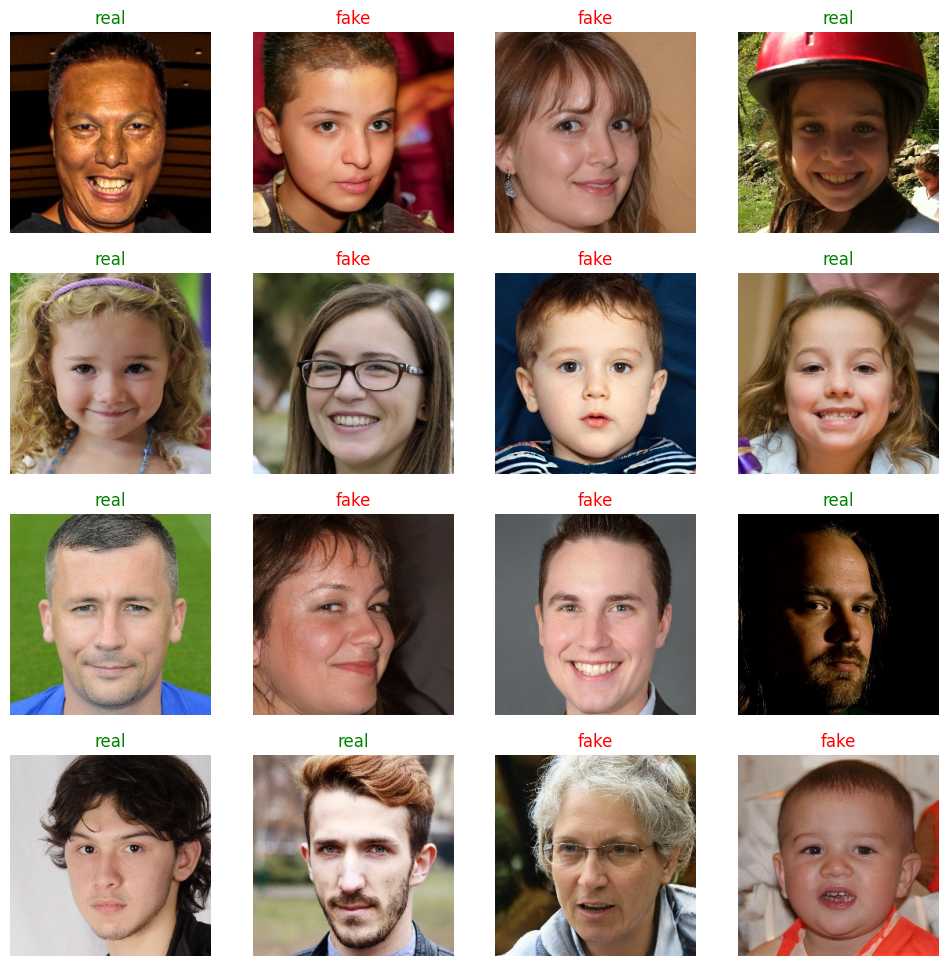

In [8]:
# Checking some images
images, labels = train_generator.next()

# Display the images along with their labels
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')

    if int(labels[i]) == 0:
        title_color = 'red'
    else:
        title_color = 'green'

    ax.set_title(classes[int(labels[i])], color=title_color)

plt.show()

## Convolutional neural network

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, DepthwiseConv2D, LeakyReLU

In [10]:
# Model
cnn = Sequential()

# Convolutional layer
cnn.add(Conv2D(32, (5, 5), activation=LeakyReLU(),padding='same',strides=(1,1),input_shape=(image_height, image_width, 3)))

# Depthwise-pointwise convolution layers to reduce computation
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(2,2)))
cnn.add(Conv2D(64, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(1,1)))
cnn.add(Conv2D(64, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(2,2)))
cnn.add(Conv2D(128, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(1,1)))
cnn.add(Conv2D(128, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(2,2)))
cnn.add(Conv2D(256, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(1,1)))
cnn.add(Conv2D(256, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(2,2)))
cnn.add(Conv2D(256, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(1,1)))
cnn.add(Conv2D(256, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(2,2)))
cnn.add(Conv2D(256, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(1,1)))
cnn.add(Conv2D(256, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(2,2)))
cnn.add(Conv2D(256, (1,1), activation=LeakyReLU()))
cnn.add(DepthwiseConv2D((3,3), activation=LeakyReLU(),padding='same',strides=(1,1)))
cnn.add(Conv2D(256, (1,1), activation=LeakyReLU()))
cnn.add(Conv2D(256, (4, 4), activation=LeakyReLU(),padding='valid',strides=(1,1)))

# # Flatten layer to feed into dense Dense
cnn.add(Flatten())

# Dense layers
cnn.add(Dense(256, activation=LeakyReLU()))
cnn.add(Dense(128, activation=LeakyReLU()))
cnn.add(Dense(1, activation='sigmoid'))  # Adjust the number of classes

In [11]:
cnn.compile(optimizer='adam'
            ,loss='binary_crossentropy'
            ,metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 depthwise_conv2d (Depthwise  (None, 128, 128, 32)     320       
 Conv2D)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      2112      
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 128, 128, 64)     640       
 seConv2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 64, 64, 64)       6

                                                                 
 conv2d_13 (Conv2D)          (None, 1, 1, 256)         1048832   
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,696,833
Trainable params: 1,696,833
Non-trainable params: 0
_________________________________________________________________


In [12]:
tf.keras.backend.clear_session()
cnn_history = cnn.fit(train_tfds, epochs=100,validation_data=valid_tfds)

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/conv2d_3/leaky_re_lu_6/LeakyRelu' defined at (most recent call last):
    File "C:\Users\sanya\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sanya\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sanya\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\sanya\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\sanya\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue
      await self.process_one()
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\ipykernel\kernelbase.py", line 518, in process_one
      await dispatch(*args)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell
      await result
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\ipykernel\kernelbase.py", line 766, in execute_request
      reply_content = await reply_content
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sanya\AppData\Local\Temp\ipykernel_18268\4286409366.py", line 2, in <module>
      cnn_history = cnn.fit(train_tfds, epochs=100,validation_data=valid_tfds)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\layers\activation\leaky_relu.py", line 72, in call
      return backend.relu(inputs, alpha=self.alpha)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env\lib\site-packages\keras\backend.py", line 5349, in relu
      return tf.nn.leaky_relu(x, alpha=alpha)
Node: 'sequential/conv2d_3/leaky_re_lu_6/LeakyRelu'
OOM when allocating tensor with shape[32,64,64,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/conv2d_3/leaky_re_lu_6/LeakyRelu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3456]

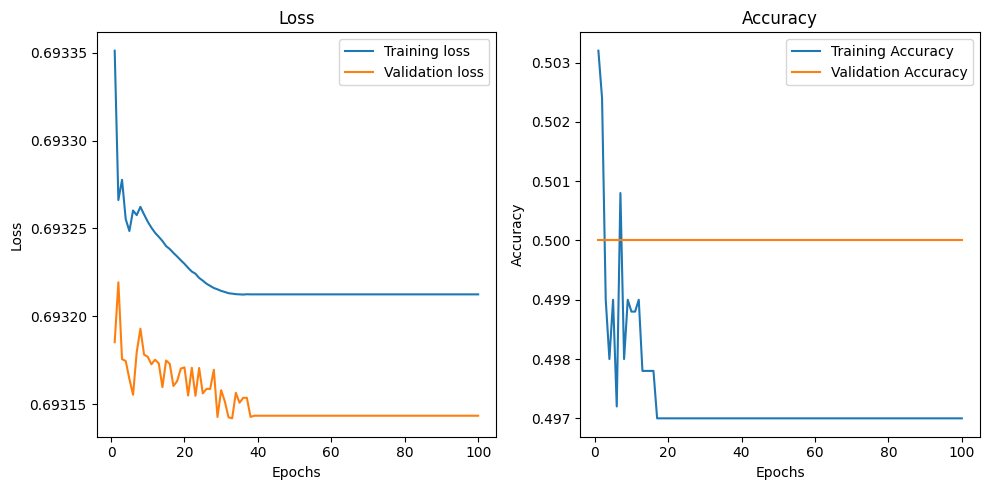

In [ ]:
# Visualizing results
training_loss = cnn_history.history['loss']
validation_loss = cnn_history.history['val_loss']
training_accuracy = cnn_history.history['accuracy']
validation_accuracy = cnn_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing set
cnn.evaluate(test_tfds)

2000/2000 [==============================] - 11s 5ms/step - loss: 0.6931 - accuracy: 0.5000


[0.693143367767334, 0.5]

Manual testing

1/1 [==============================] - 0s 239ms/step
[[0.5021428]]


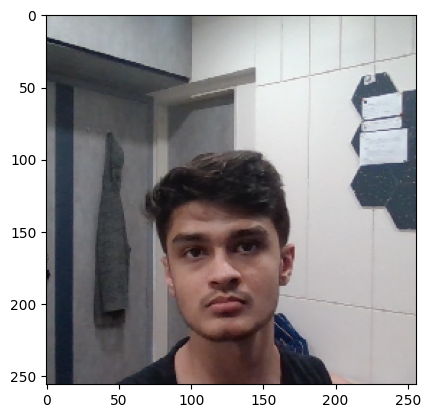

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Real image
img_path = "manual_test_images/Real.jpg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))
prediction = cnn.predict(img_array)
print(prediction)

1/1 [==============================] - 0s 18ms/step
[[0.5021428]]


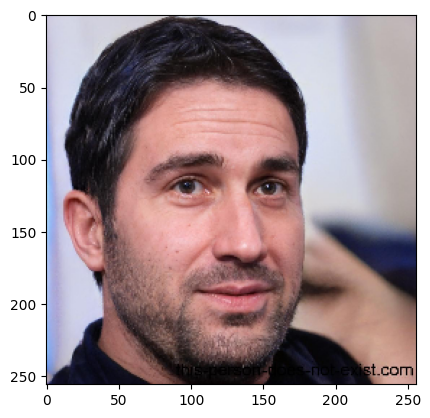

In [ ]:
# Fake image(hard)
img_path = "manual_test_images/Hard.jpeg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))
prediction = cnn.predict(img_array)
print(prediction)

1/1 [==============================] - 0s 19ms/step
[[0.5021428]]


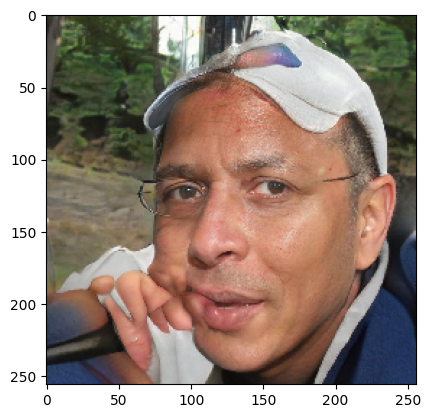

In [ ]:
# Fake image(medium)
img_path = "manual_test_images/Medium.jpg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))
prediction = cnn.predict(img_array)
print(prediction)

1/1 [==============================] - 0s 21ms/step
[[0.5021428]]


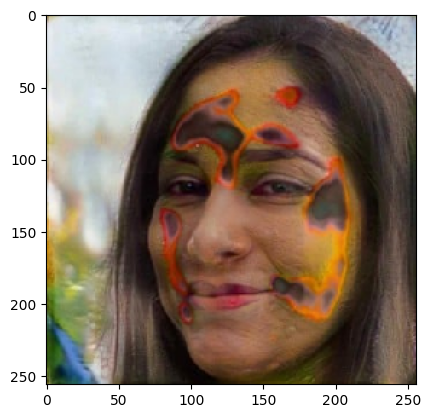

In [ ]:
# Fake image(easy)
img_path = "manual_test_images/Easy.jpg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))
prediction = cnn.predict(img_array)
print(prediction)

In [13]:
# Saving model
from datetime import datetime
filename = f'models/cnn_{datetime.now().timestamp()}.h5'
tf.keras.models.save_model(cnn, filename)